# How the green crab env works

In [1]:
import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_density, geom_line, geom_point, 
    geom_violin, facet_grid, labs, theme, facet_wrap,
)
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective

# the rl environment
from rl4greencrab import greenCrabSimplifiedEnv as gcse

# helper that paralelizes episode simulations for evaluation purposes (agent -> reward)
from rl4greencrab import evaluate_agent

# helper that creates a single episode simulation keeping track of many variables
# of the internal env state
from rl4greencrab import simulator

# two types of constant action policy:
# constAction = choose one trap type and an intensity of trapping effort 
#     (e.g. number of traps)
# multiConstAction = choose intensities of trapping efforts for each trap type
#     (strictly contains costAction as the subset of possible policies which 
#     have non-zero intensities for only one trap type)
from rl4greencrab import constAction, multiConstAction

In [2]:
gc_env = gcse()
gc_env.reset()

(array([-1., -1.], dtype=float32), {})

In [3]:
(
    gc_env.action_space,
    gc_env.observation_space
)

(Box(-1.0, 1.0, (3,), float32), Box(-1.0, 1.0, (2,), float32))

## Crab size distribution

/tmp/ipykernel_38592/3679518668.py:20: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 21 rows containing missing values.


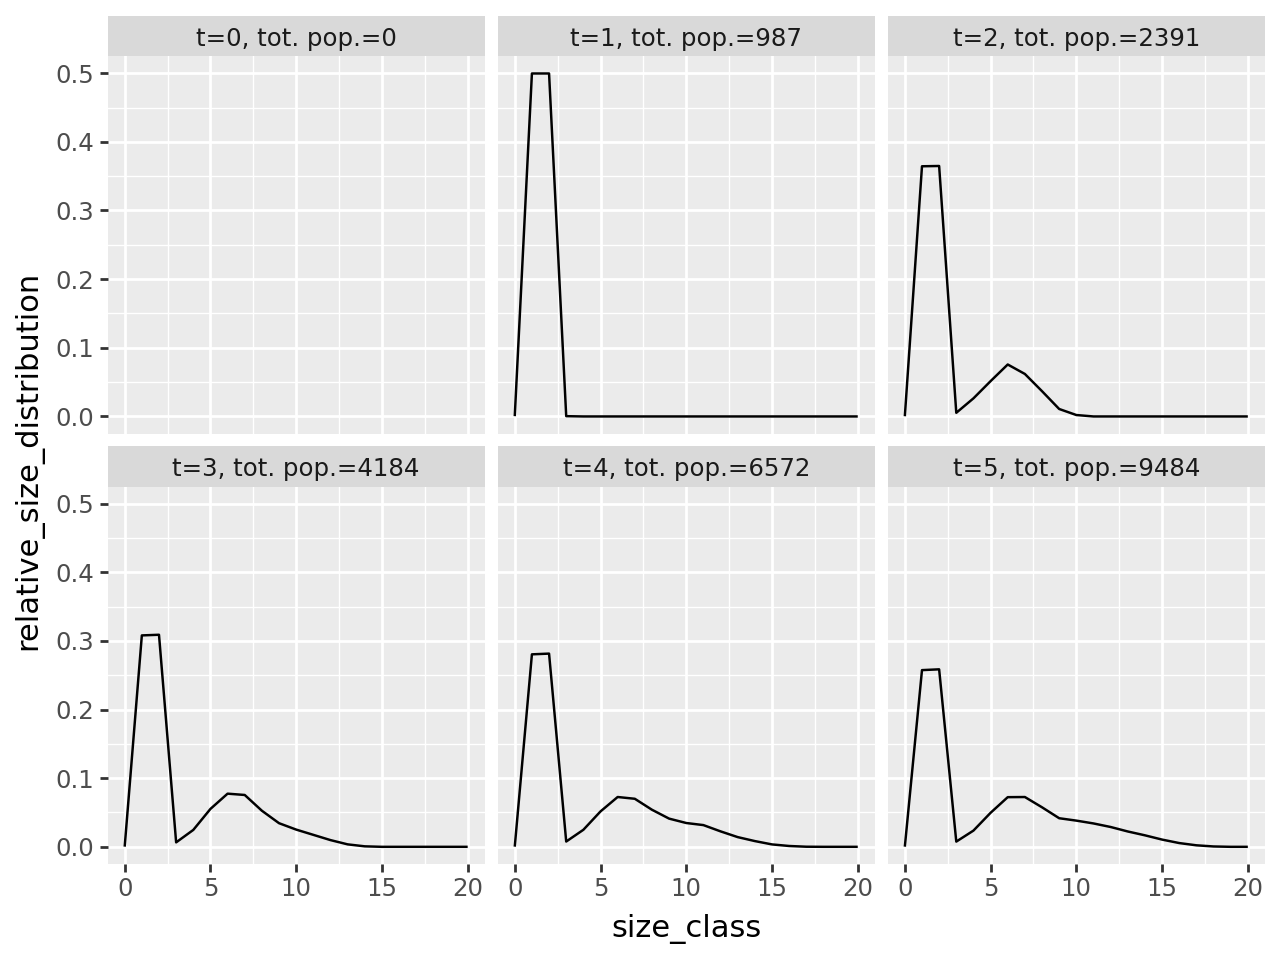

In [4]:
some_action_choices = {
    'not my problem': np.array([-1,-1,-1]), # do nothing
    'must eliminate': np.array([1,1,1]), # do maximum effort
    'moderate': np.array([-0.8, -0.8, -0.8]),
    'm trap max': np.array([1, -1, -1]), # only use m traps, go all out
    'f trap max': np.array([-1, 1, -1]), # only use f traps, go all out
    's trap max': np.array([-1, -1, 1]), # only use s traps, go all out
}

# you can change it to another one of the options or an action you want to explore
action = some_action_choices['not my problem'] 

gc_env.reset()

size_dist = pd.DataFrame()

for t in range(6):
    new_size_dist = pd.DataFrame(
        {
            'relative_size_distribution': gc_env.state / sum(gc_env.state),
            'size_class': list(range(21)),
            'label': 21*[f"t={t}, tot. pop.={int(sum(gc_env.state))}"],
        }
    )
    size_dist = pd.concat(
        [size_dist, new_size_dist],
        ignore_index=True,
    )
    gc_env.step(action)
(
    ggplot(size_dist, aes(x='size_class',y='relative_size_distribution')) 
    + geom_line() 
    + facet_wrap(facets='label',) 
    # + labs(title=f"N. traps = 0, final pop = {sum(gce.state):.0f}")
    + theme(aspect_ratio=1)
)

## Optimizing constant strategies

In [5]:
# helper function (should maybe integrate it as part of the source code actually)
def evaluateConstAct(x):
    # use defaults for env config, but can be modified as best fits
    # your experiments
    ENV_CONFIG = {} 
    env = gcse(config = ENV_CONFIG)

    # compute average reward
    N_EPS = 200
    agent = multiConstAction(env=env, action=np.array(x))
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
    return - m_reward

In [6]:
res = gp_minimize(evaluateConstAct, 3*[(-1.0, 1.0)], n_calls = 100, verbose=True)
print(f"""
optimal constant action = {res.x}
opt. const. act. reward = {res.fun}
""")

Iteration No: 1 started. Evaluating function at random point.


2024-10-30 22:18:26,512	INFO worker.py:1816 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.0750
Function value obtained: 8.7851
Current minimum: 8.7851
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3937
Function value obtained: 238.3255
Current minimum: 8.7851
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3972
Function value obtained: 129.9871
Current minimum: 8.7851
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3894
Function value obtained: 208.2968
Current minimum: 8.7851
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3948
Function value obtained: 7.4367
Current minimum: 7.4367
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evalua

(raylet) [2024-10-30 22:46:44,256 E 38978 38978] (raylet) node_manager.cc:3069: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 05fee40498becfc5e2d8d666115ea9442b9d7f97ad9ffccb7472cdf3, IP: 10.42.0.194) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.42.0.194`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) 
(raylet) [2024-10-30 22:47:44,257 E 38978 38978] (raylet) node_manager.cc:3069: 7 Workers (tasks / actors) ki

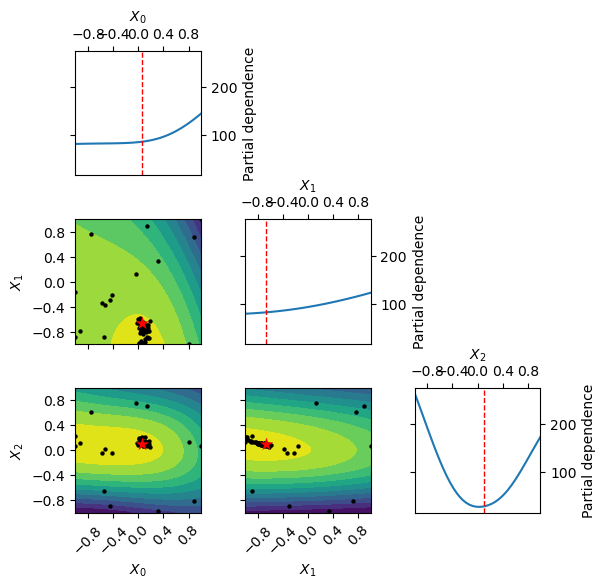

In [7]:
import matplotlib.pyplot as plt
plt.close()
plot_objective(res)
plt.show()